In [1]:
using Pkg

projectdir_static = dirname(Base.active_project())

projectdirx(args...) = joinpath(projectdir_static, args...)

# Generate functions to access the path of default subdirectories.
for dir_type ∈ ("data", "src", "plots", "scripts", "papers")
    function_name = Symbol(dir_type * "dirx")
    @eval begin
        $function_name(args...) = projectdirx($dir_type, args...)
    end
end

using DrWatson

@quickactivate "TissueRigidity"
 
projectname()

"TissueRigidity"

In [2]:
using DifferentialEquations
using StatsBase
using CairoMakie
using XLSX
using DataFrames
using Optimization, OptimizationPolyalgorithms, SciMLSensitivity,OptimizationOptimJL,OptimizationBBO,OptimizationNOMAD

┌ Warning: Error requiring `Enzyme` from `LinearSolve`
│   exception =
│    LoadError: ArgumentError: Package LinearSolve does not have Enzyme in its dependencies:
│    - You may have a partially installed environment. Try `Pkg.instantiate()`
│      to ensure all packages in the environment are installed.
│    - Or, if you have LinearSolve checked out for development and have
│      added Enzyme as a dependency but haven't updated your primary
│      environment's manifest file, try `Pkg.resolve()`.
│    - Otherwise you may need to report an issue with LinearSolve
│    Stacktrace:
│      [1] macro expansion
│        @ ./loading.jl:1167 [inlined]
│      [2] macro expansion
│        @ ./lock.jl:223 [inlined]
│      [3] require(into::Module, mod::Symbol)
│        @ Base ./loading.jl:1144
│      [4] include(mod::Module, _path::String)
│        @ Base ./Base.jl:419
│      [5] include(x::String)
│        @ LinearSolve ~/.julia/packages/LinearSolve/qCLK7/src/LinearSolve.jl:1
│      [6] macro 

In [3]:
include(srcdirx("Plotting&Utility.jl"))
include(srcdirx("FittingFunctions.jl"))

include(srcdirx("NodalLefty_E.jl"))

exp_name = "NodalLefty_DiffusionDominated"

include(srcdirx("ExperimentSetups/" * exp_name * ".jl"))

include(scriptsdirx("LoadData.jl"));

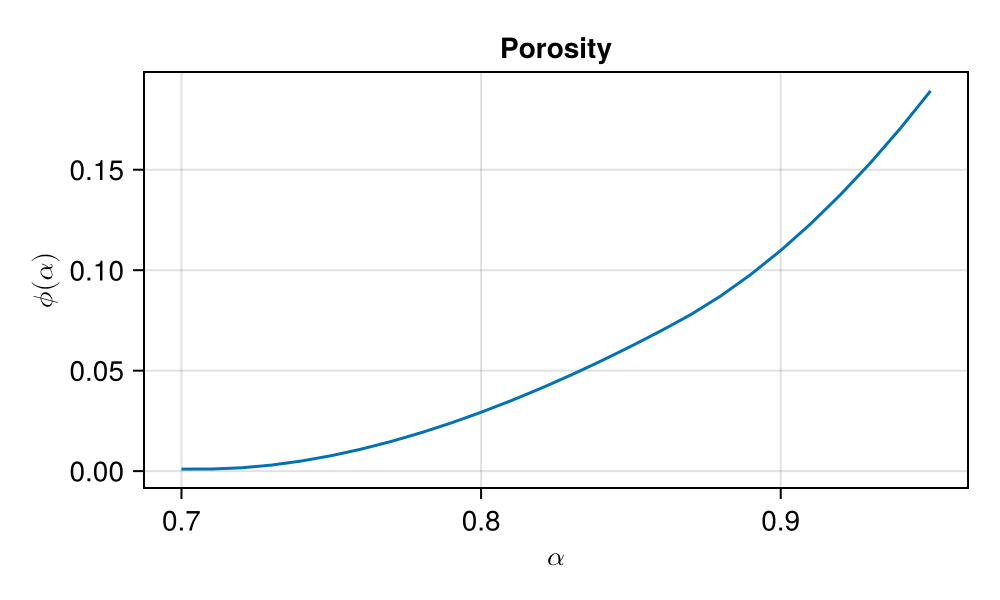

In [4]:
α_range = 0.7:0.01:0.95

fig = Figure(size = (500,300))
ax1 = Axis(fig[1,1],title = "Porosity",ylabel = L"\phi(\alpha)",xlabel = L"\alpha")

lines!(ax1, α_range,[ϕ(α) for α in α_range])

fig

In [5]:
pv_orig = [DN0,DL0,kN0,kL0,kE,kNL,σN0,σL0,Na,NL,NE,LN,s0]

p_orig,p_cp_orig,p_lm_orig = get_params(pv_orig)

tspan = (0,Inf)

u0 = ones(Nc,4)

u0[:,1] .= 1e-10
u0[:,2] .= 1e-10
u0[:,3] .= 0.
u0[:,4] .= α0

prob = ODEProblem(nodal_lefty_spatial_diff!,u0,tspan,p_orig)

lb = copy(pv_orig)
ub = copy(pv_orig)

lb[1:2] = 0.9 .* lb[1:2]
ub[1:2] = 1.1 .* ub[1:2]

lb[3:end] = (1 - γ) .* lb[3:end]
ub[3:end] = (1 + γ) .* ub[3:end];

In [6]:
orig_metrics = get_summary_metrics_binned(pv_orig,prob,data,alpha_data)

(wt_t0 = 1961.1160088933193, cp_t0 = 3475.395458798288, wt_xMax = 93.31103678929766, cp_xMax = 154.51505016722408, lm_xMax = 300.0, wt_d0 = 0.07526881720430108, cp_d0 = 0.44805194805194803, lm_d0 = 1.0, xmax_peak_ratio = 1.7721518987341776, xmax_mse = (0.20828222855309078, 0.9788093262911168), alpha_mse = 0.0026416048298987735, cp_lprod_t0 = 1836.9947425076662, wt_lprod_t0 = 1290.8611704107925, retcodes = (SciMLBase.ReturnCode.Terminated, SciMLBase.ReturnCode.Terminated, SciMLBase.ReturnCode.Terminated))

In [7]:
include(srcdirx("FittingFunctions.jl"))

# orig_metrics = get_summary_metrics_binned(pv_orig,prob,data,alpha_data)

generate_param_set (generic function with 1 method)

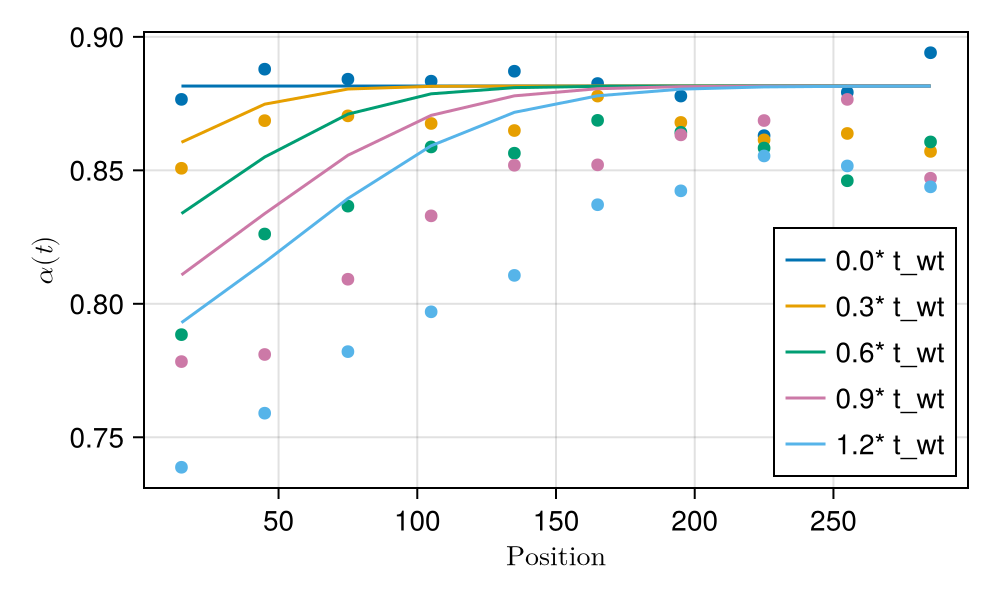

In [8]:
# (t_grid_alpha,dyn_alpha),(t_plot,(level_x_wt_rescaled,level_x_cp_rescaled,level_x_lm)),c_level,wt_t0,sol,sol_cp = get_alpha_xmax_binned(pv_orig,prob);

(t_grid_alpha,dyn_alpha),(t_plot,(level_x_wt_rescaled,level_x_cp_rescaled,level_x_lm)),(porosity_dyn,porosity_dyn_cp) = get_alpha_xmax(pv_orig,prob);

fig = Figure(size = (500,300))

ax = Axis(fig[1,1], xlabel = L"\text{Position}", ylabel= L"α(t)" )

for (n,d) in enumerate(dyn_alpha)
    lines!(ax,alpha_x,d, label = string(alpha_data_times_norm[n])* "* t_wt")
    scatter!(ax,alpha_x,alpha_data[:,n+1])
end

axislegend(ax,position = :rb)

# save(plotsdir(exp_name * "/OrigFits/Alpha_over_time.pdf"),fig)

fig

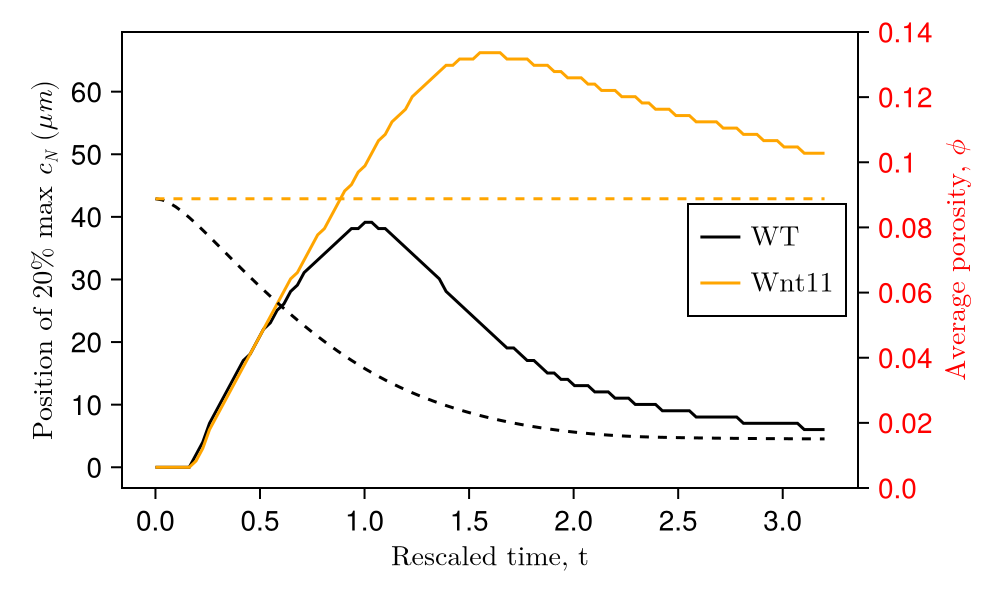

In [9]:
fig = Figure(size = (500,300))

ax = Axis(fig[1,1], xlabel = L"\text{Rescaled time, t}", ylabel= L"\text{Position of 20% max } c_N \text{ } (μm) ",ygridvisible = false,xgridvisible = false)
ax_por = Axis(fig[1,1], xlabel = L"\text{Rescaled time, t}", ylabel= L"\text{Average porosity, } \phi", yaxisposition = :right,ylabelcolor = :red,yticklabelcolor = :red,ygridvisible = false,xgridvisible = false,xticksvisible = false)

hidexdecorations!(ax_por)

lines!(ax,t_plot,level_x_wt_rescaled,color = :black,label = L"\text{WT}")
lines!(ax,t_plot,level_x_cp_rescaled,color = :orange,label = L"\text{Wnt11}")
# lines!(ax,t_plot,level_x_lm,linestyle = :dash,color = :pink,label = L"\text{Lefty mutant}")

lines!(ax_por,t_plot,porosity_dyn ,linestyle = :dash,color = :black,label = L"\text{ϕ}")
lines!(ax_por,t_plot,porosity_dyn_cp ,linestyle = :dash,color = :orange,label = L"\text{ϕ}")

# lines!(ax,exp_times_times_norm ,data[:,"SLB"],color = :blue)
# lines!(ax,exp_times_times_norm ,data[:,"WT"],color = :black)

axislegend(ax,position = :rc)

ylims!(ax_por,0.,0.14)

ax.xticks = (0:0.5:3.5,string.(0:0.5:3.5))

ax_por.yticks = (0:0.02:0.14,string.(0:0.02:0.14))

save(plotsdir(exp_name * "/OrigFits/Fig3E_xmax_over_time_wporosity_no_av.pdf"),fig)

fig

In [10]:
t_check = [15,40,65,90,115,140] .* 60

sol_profiles = solve(prob, p = p_orig, FBDF(),abstol = de_abstol,reltol = de_reltol, maxiters = 1e6,callback = TerminateSteadyState(1e-6,1e-4),isoutofdomain = (u,p,t) -> any(x->x<0, u), saveat = t_check);

dyn_N = [sol[:,1] for sol in sol_profiles.u[1:6]]
dyn_L = [sol[:,2] for sol in sol_profiles.u[1:6]];

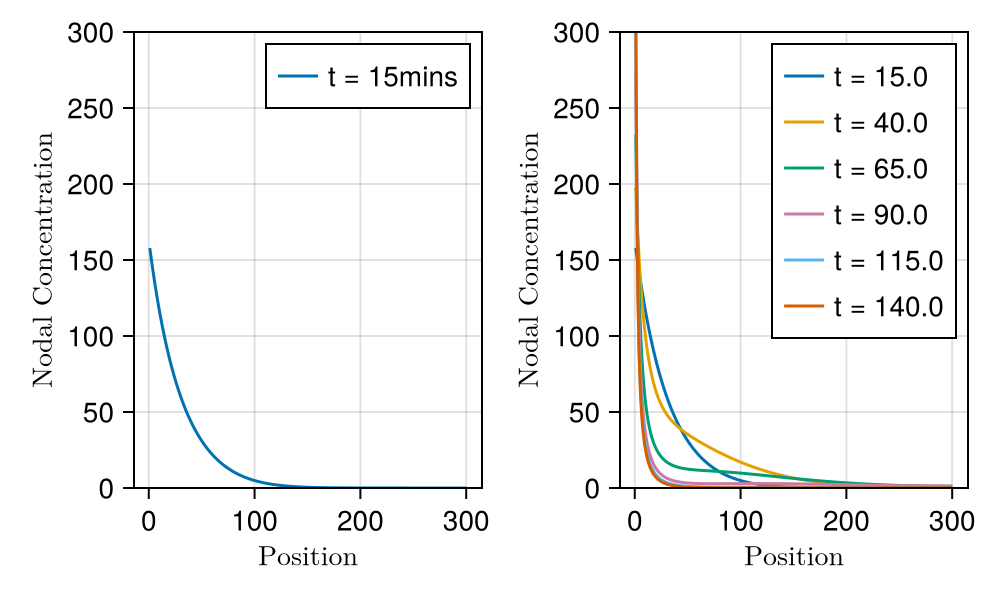

In [11]:
fig = Figure(size = (500,300))

ax1 = Axis(fig[1,1], xlabel = L"\text{Position}", ylabel= L"\text{Nodal Concentration}" )

lines!(ax1,dyn_N[1],label = "t = 15mins")

ax2 = Axis(fig[1,2], xlabel = L"\text{Position}", ylabel= L"\text{Nodal Concentration}" )

for (i,N) in enumerate(dyn_N)
    lines!(ax2,N,label = "t = " * string(sol_profiles.t[i] / 60))
end

axislegend(ax1,position = :rt)
axislegend(ax2,position = :rt)

ylims!(ax1,0,300.)
ylims!(ax2,0,300.)

ax1.yticks = (0:50:300,string.(0:50:300))
ax2.yticks = (0:50:300,string.(0:50:300))

save(plotsdir(exp_name * "/OrigFits/NodalProfiles.pdf"),fig)

fig

In [12]:
# dyn_N = [sol(t)[:,1] for t in t_check]
# dyn_L = [sol(t)[:,2] for t in t_check]

In [13]:
cNt_cp = [sol[:,1] for sol in sol_cp.u]
αt_cp = [sol[:,4] for sol in sol_cp.u]

cNt = [sol[:,1] for sol in sol.u]
αt = [sol[:,4] for sol in sol.u];

νN_int_cp = [trapezoid_rule(ν.(cN,σ.(σL0,ϕ0,ϕ.(α)),NL,mL),1) for (cN,α) in zip(cNt_cp,αt_cp)];
νN_int = [trapezoid_rule(ν.(cN,σ.(σL0,ϕ0,ϕ.(α)),NL,mL),1) for (cN,α) in zip(cNt,αt)];

fig = Figure(size = (500,300))
ax = Axis(fig[1,1], xlabel = L"\text{t, mins}", ylabel= L"\int_0^L ν_L(N(t,x)) dx" )

lines!(ax,sol_cp.t ./ 60,νN_int_cp,linestyle = :dash,color = :grey, label = L"\text{Wnt11}")
lines!(ax,sol.t ./ 60,νN_int,color = :grey, label = L"\text{WT}")

xlims!(ax,0.,100)

# ylims!(ax,0.,0.16)

axislegend(ax,position = :rt)

save(plotsdir(exp_name * "/OrigFits/Fig4h_Integrated_Lprod_over_Time.pdf"),fig)

fig

LoadError: UndefVarError: sol_cp not defined

In [13]:
data_metrics = get_exp_summary_metrics(data)

(wt_t0 = 6000.0, cp_t0 = 8400.0, wt_xMax = 63.9966, cp_xMax = 86.59800000000001, wt_d0 = 0.0, cp_d0 = 0.0, lm_d0 = 1.0, xmax_peak_ratio = 1.4, xmax_mse = 0.0, alpha_mse = 0.0)

In [ ]:
sim_data = load(datadirx("sims/" * exp_name * "_Sweep.jld2"))

In [ ]:
# sim_res = copy(sim_data["Results"]);

sim_res_id = findall(t->!haskey(t,:DN0),sim_data["Results"]);

sim_res = copy(sim_data["Results"][sim_res_id])

length(sim_res)

In [ ]:
sim_param = [get_params(p_vector) for p_vector in sim_data["Parameters"][sim_res_id]]

sim_p = [p_tuple[1] for p_tuple in sim_param]
sim_p_cp = [p_tuple[2] for p_tuple in sim_param]
sim_p_lm = [p_tuple[3] for p_tuple in sim_param];

In [ ]:
orig_sim = get_summary_metrics(pv_orig,prob,data,alpha_data)

In [26]:
metric_names = [:wt_t0,:cp_t0,:wt_xMax,:cp_xMax,:lm_xMax,:wt_d0,:cp_d0,:lm_d0,:xmax_peak_ratio,:xmax_mse,:alpha_mse,:retcodes]
metric_names_string = Dict(:wt_t0 => "wt_t0",:cp_t0=>"cp_t0",:wt_xMax=>"wt_xMax",:cp_xMax=>"cp_xMax",:lm_xMax=>"lm_xMax",:wt_d0=>"wt_d0",:cp_d0=>"cp_d0",:lm_d0=>"lm_d0",:xmax_peak_ratio=>"xmax_peak_ratio",:xmax_mse=>"xmax_mse",:alpha_mse=>"alpha_mse")

metric_names_latex = Dict(:wt_t0 => L"t_{\text{WT}}",:cp_t0 => L"t_{\text{wnt11}}",:wt_xMax=>L"X_{\text{max}}^{\text{WT}}",:cp_xMax=>L"X_{\text{max}}^{\text{wnt11}}",
:lm_xMax=>L"X_{\text{max}}^{\text{lefty}}",:wt_d0=>L"X_{\text{end}}^{\text{WT}} / X_{\text{max}}^{\text{WT}}",:cp_d0=>L"X_{\text{end}}^{\text{wnt11}} / X_{\text{max}}^{\text{wnt11}}",
:lm_d0=>L"X_{\text{end}}^{\text{lefty}} / X_{\text{max}}^{\text{lefty}}",:xmax_peak_ratio=>L"t_{\text{wnt11}} / t_{\text{WT}}",:xmax_mse => L"X_{\text{max}}^{MSE}",:alpha_mse=>L"\alpha_{\text{max}}^{MSE}")

transformations = Dict(:wt_t0 => t -> t / 60,:cp_t0 => t -> t / 60,:wt_xMax => t -> t ,:cp_xMax => t -> t ,:lm_xMax => t -> t ,:wt_d0 => t -> t ,:cp_d0 => t -> t ,:lm_d0 => t -> t ,:xmax_peak_ratio => t -> t ,:xmax_mse => t -> t,:alpha_mse=> t -> t);

In [27]:
p_names = [:DN0,:DL0,:kN0,:kL0,:kE,:kNL,:σN0,:σL0,:Na,:NL,:NE,:LN,:s0]
p_names_id = Dict(:DN0=>1,:DL0=>2,:kN0=>3,:kL0=>4,:kE=>5,:kNL=>6,:σN0=>7,:σL0=>8,:Na=>9,:NL=>10,:NE=>11,:LN=>12,:s0=>13)

p_names_latex = Dict(:DN0 => L"D_N^0",:DL0 =>L"D_L^0",:kN0=>L"K_N^0",:kL0=>L"K_L^0",:kE => L"k_E",:kNL => L"k_{NL}",:σN0 => L"\sigma_{N}^{0}",:σL0 => L"\sigma_{L}^{0}",:Na => L"N_a",:NL => L"N_L",:NE => L"N_E",:LN => L"L_N",:s0 => L"s_0");
p_names_string = Dict(:DN0 => "D_N0",:DL0 => "D_L0",:kN0=>"K_N0",:kL0 =>"K_L0",:kE => "k_E",:kNL => "k_NL",:σN0 => "σN0",:σL0 => "σL0",:Na => "N_a",:NL => "N_L",:NE => "N_E",:LN => "L_N",:s0 => "s_0");

In [ ]:
# ent_var = [calculate_entropy(map(x->x[var_name],sim_p[sim_crit]),20,lb[p_names_id[var_name]],ub[p_names_id[var_name]]) for var_name in p_names]

# min_ent_var = p_names[argmin(ent_var)]

In [ ]:
metrics_to_plot = [:xmax_peak_ratio,:wt_d0,:cp_d0,:alpha_mse]

all_pw_figs = []

quantile_ϵ = 0.01

for metric in metrics_to_plot
  
    sim_Δ =  map(x->abs(x[metric] - data_metrics[metric]),sim_res)

    sim_crit = findall(sim_Δ .<= quantile(sim_Δ,quantile_ϵ));

    all_corr = []
    all_corr_pairs = []

    for (ni,p_name_i) in enumerate(p_names)
        for (nj,p_name_j) in enumerate(p_names)
            if ni < nj
                push!(all_corr,abs(corspearman(map(x->x[p_name_i],sim_p[sim_crit]),map(x->x[p_name_j],sim_p[sim_crit]))))
                push!(all_corr_pairs,(p_name_i,p_name_j))
            end
        end
    end

    top_corr_id = sortperm(all_corr, rev = true);

    ####################

    fig = Figure(size = (700,500),fontsize = 15.)

    top_n = 5

    ax_grid = Tuple.(findall(x->x>0,ones(2,Int((top_n+1) / 2))))

    ax = Axis(fig[ax_grid[1]...], ylabel = L"| \rho |",title = metric_names_latex[metric])

    barplot!(ax,all_corr[top_corr_id[1:top_n]],color = (:grey,0.5))

    top_n_corr_pairs = all_corr_pairs[top_corr_id[1:top_n]]

    ax.xticks = (1:top_n,[p_names_string[vi] * " / " * p_names_string[vj] for (vi,vj) in top_n_corr_pairs])

    ax.xticklabelrotation = 45.

    for (n,var_pair) in enumerate(top_n_corr_pairs)
        ax = Axis(fig[ax_grid[n+1]...],xlabel = p_names_latex[var_pair[1]], ylabel = p_names_latex[var_pair[2]],xscale = log10,yscale = log10,xticks = LogTicks(WilkinsonTicks(4)),yticks = LogTicks(WilkinsonTicks(4)))
        scatter!(ax,map(x->x[var_pair[1]],sim_p[sim_crit]),map(x->x[var_pair[2]],sim_p[sim_crit]),markersize = 4.,color = :grey)
        scatter!(ax,[p_orig[var_pair[1]]],[p_orig[var_pair[2]]], markersize = 10., color = :red,marker = 'x')
    end

    push!(all_pw_figs,fig)

    save(plotsdir(exp_name * "/ParamSweeps/" * metric_names_string[metric] * "_exp_match_pairwise.pdf"),fig)
end

In [ ]:
all_pw_figs[1]

In [ ]:
all_p_metric_figs = []

for metric in metrics_to_plot

    p_metric_cor = [abs(corspearman(map(x->x[p],sim_p),map(x->x[metric],sim_res))) for p in p_names]

    metric_val = map(x->x[metric],sim_res)

    ax_grid = Tuple.(findall(ones(4,4) .> 0))

    fig = Figure(size = (1000,1000),fontsize = 15.)

    for (n,p) in enumerate(p_names)
        cor_title = string(round(abs(corspearman(map(x->x[p],sim_p),metric_val)),digits = 2))
        ax = Axis(fig[ax_grid[n]...],xlabel = p_names_latex[p],ylabel = metric_names_latex[metric],title = "Corr = " * cor_title, xscale = log10,xticks = LogTicks(WilkinsonTicks(4)))
        scatter!(map(x->x[p],sim_p),metric_val, markersize = 3.,color = (:grey,0.5))
        vlines!(ax,p_orig[p], linestyle = :dash, color = :red)
    end

    push!(all_p_metric_figs,fig)

    save(plotsdir(exp_name * "/ParamSweeps/" * metric_names_string[metric] * "_vs_parameters.pdf"),fig)

end

In [ ]:
all_p_metric_figs[3]

In [ ]:
to_plot = [:wt_t0,:cp_t0,:xmax_peak_ratio,:wt_xMax,:cp_xMax,:wt_d0,:cp_d0,:lm_d0,:alpha_mse]

fig = Figure(size = (760,760))

grid_ax = Tuple.(findall(x->x>0,ones(3,3)))


for (n,metric) in enumerate(to_plot)
    if metric  == :alpha_mse
        ax = Axis(fig[grid_ax[n]...],xlabel = metric_names_latex[metric],xscale = log10)
        hist!(ax,map(x->transformations[metric](x[metric]),sim_res),normalization = :probability,color = (:grey,0.6),bins = 50)
        vlines!(ax,transformations[metric](orig_metrics[metric]),color = :blue,linestyle = :dash)
    else
        ax = Axis(fig[grid_ax[n]...],xlabel = metric_names_latex[metric])
        hist!(ax,map(x->transformations[metric](x[metric]),sim_res),normalization = :probability,color = (:grey,0.6),bins = 50)
        vlines!(ax,transformations[metric](data_metrics[metric]),color = :red,linestyle = :dash, label = L"\text{Experiment}")
        vlines!(ax,transformations[metric](orig_metrics[metric]),color = :blue,linestyle = :dash, label = L"\text{Start param.}")
    end

    if metric == :xmax_peak_ratio
        axislegend(ax,position = :rt)
    end
    
end

fig

In [ ]:
# γ = 0.99

# lb = copy(pv_orig)
# ub = copy(pv_orig)

# lb[1:2] = 0.9 .* lb[1:2]
# ub[1:2] = 1.1 .* ub[1:2]

# lb[3:end] = (1 - γ) .* lb[3:end]
# ub[3:end] = (1 + γ) .* ub[3:end];

In [32]:
@assert check_inbounds(pv_orig,lb,ub)[1]

include(srcdirx("FittingFunctions.jl"))

optf = Optimization.OptimizationFunction((x, p) -> loss_safe(x,prob,data,alpha_data))

# optf = Optimization.OptimizationFunction((x, p) -> metric_loss(x,prob,data_metrics,alpha_data))

# optf = Optimization.OptimizationFunction((x, p) -> metric_loss_safe(x,prob,data_metrics,alpha_data))

optprob = Optimization.OptimizationProblem(optf,pv_orig,lb = lb, ub = ub);

In [33]:
# const p_error = []

# include(srcdirx("FittingFunctions.jl"))
# include(srcdirx("NodalLefty_E_Diag.jl"))


In [34]:
# pv = [1.83413, 16.4574, 1.4898e-6, 4.17e-7, 0.000351, 0.09053, 0.02, 0.006, 28.15560000000001, 120.824, 11.85855, 31.6142, 6.4967]
const de_abstol = 1e-10
const de_reltol = 1e-8

result_opt = Optimization.solve(optprob,NOMADOpt(),maxiters = 50);

1   1.189733
2   1.170887
5   1.16769 
6   1.098981
7   0.949701
8   0.885409
9   0.773051
10   0.715123
12   0.710696
19   0.675622
20   0.671111
26   0.665468
34   0.646887
35   0.608885
36   0.60069 
38   0.545653
39   0.374558
42   0.328386
A termination criterion is reached: Maximum number of blackbox evaluations (Eval Global) 50

Best feasible solution:     #5139 ( 1.755 16.5 1.25e-06 1.35e-06 0.0008 16 0.018 0.012 56.921 130 21.7171 3.16228 5 )	Evaluation OK	 f =   0.32838600000000001122	 h =   0                     

Best infeasible solution:   Undefined.

Blackbox evaluations:         50
Total model evaluations:      5818
Cache hits:                   4
Total number of evaluations:  54


In [35]:
p_opt,p_cp_opt,p_lm_opt = get_params(result_opt.u)

p_opt_metrics = get_summary_metrics(result_opt.u,prob,data,alpha_data)

mse_all = loss_components(result_opt.u,prob,data,alpha_data)

((0.050752609081326824, 0.12659872071257017), 0.0072704237752419625)

In [37]:
p_opt_metrics

(wt_t0 = 589.0659079692975, cp_t0 = 779.6460546652467, wt_xMax = 26.08695652173913, cp_xMax = 36.12040133779264, lm_xMax = 300.0, wt_d0 = 0.07692307692307693, cp_d0 = 0.3055555555555556, lm_d0 = 1.0, xmax_peak_ratio = 1.3235294117647056, xmax_mse = (0.07975528658389333, 0.15732324482370288), alpha_mse = 0.008043162269828402, cp_lprod_t0 = 693.018715257997, wt_lprod_t0 = 6393.097648255022, retcodes = (SciMLBase.ReturnCode.Terminated, SciMLBase.ReturnCode.Terminated, SciMLBase.ReturnCode.Terminated))

In [19]:
# a = []
# push!(a,result_opt.u)

In [20]:
sol = solve(prob, p = p_opt, FBDF(),abstol = de_abstol,reltol = de_reltol,maxiters = 1e6,callback = TerminateSteadyState(1e-6,1e-4),isoutofdomain = (u,p,t) -> any(x->x<0, u));
sol_lm = solve(prob, p = p_cp_opt, FBDF(),abstol = de_abstol,reltol = de_reltol, maxiters = 1e6,callback = TerminateSteadyState(1e-6,1e-4),isoutofdomain = (u,p,t) -> any(x->x<0, u));
sol_cp = solve(prob, p = p_lm_opt, FBDF(),abstol = de_abstol,reltol = de_reltol,maxiters = 1e6,callback = TerminateSteadyState(1e-6,1e-4),isoutofdomain = (u,p,t) -> any(x->x<0, u));

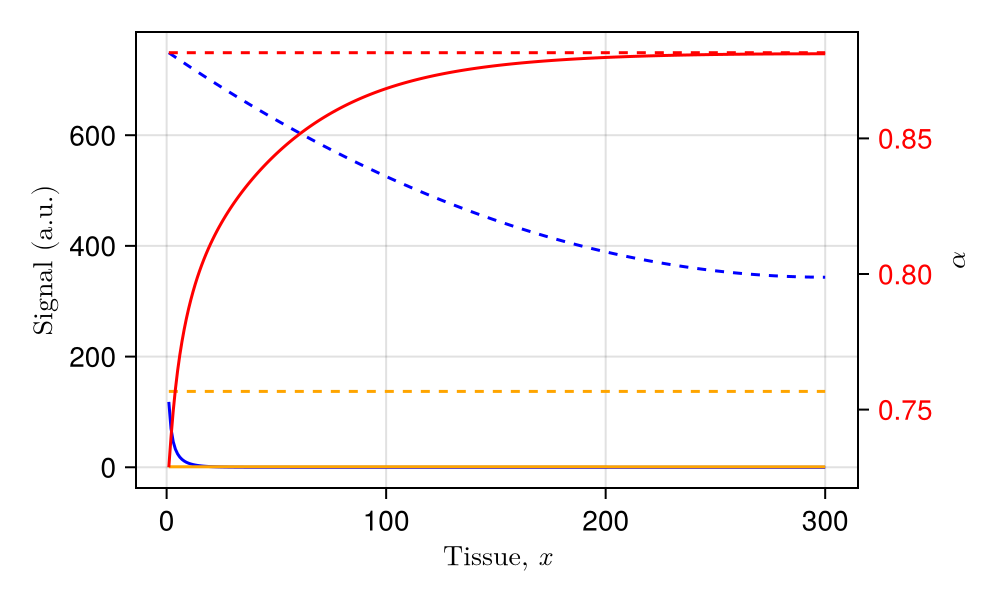

In [21]:
fig = Figure(size = (500,300))
ax = Axis(fig[1,1], xlabel = L"\text{Tissue, } x", ylabel = L"\text{Signal (a.u.)}")
ax_alpha = Axis(fig[1,1], yaxisposition = :right,ygridvisible = false,xgridvisible = false,yticklabelcolor = :red,ylabel = L"\alpha")

hidespines!(ax_alpha)
hidexdecorations!(ax_alpha)

plot_steady_state_profiles!(ax,ax_alpha,sol,:solid)
plot_steady_state_profiles!(ax,ax_alpha,sol_cp,:dash)

# save(plotsdir("EndProfiles.pdf"),fig)

fig

In [22]:
(t_grid_alpha,dyn_alpha),(t_plot,(level_x_wt_rescaled,level_x_cp_rescaled,level_x_lm)),(porosity_dyn,porosity_dyn_cp) = get_alpha_xmax(result_opt.u,prob);

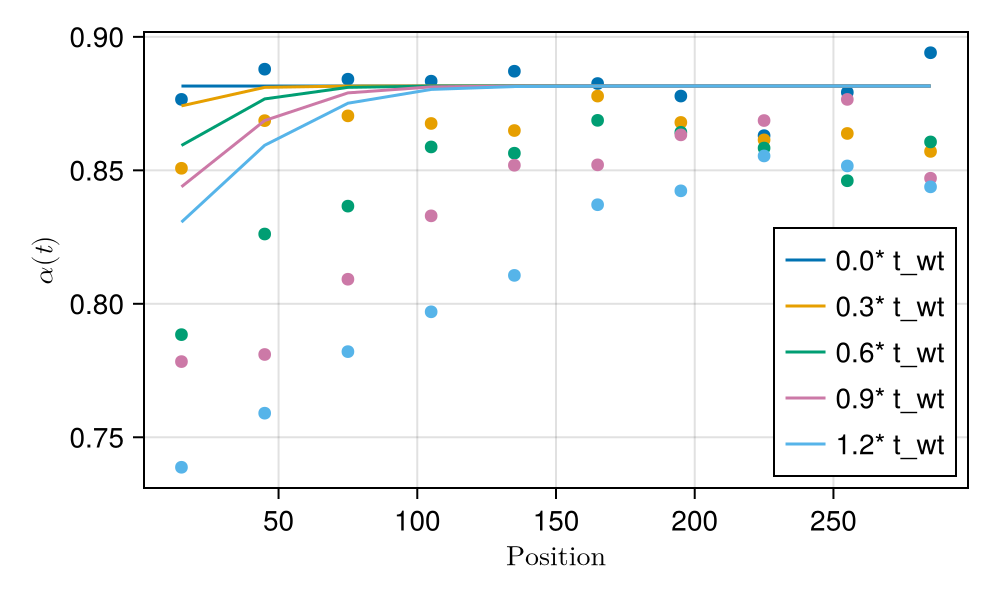

In [23]:
fig = Figure(size = (500,300))

ax = Axis(fig[1,1], xlabel = L"\text{Position}", ylabel= L"α(t)" )

for (n,d) in enumerate(dyn_alpha)
    lines!(ax,alpha_x,d, label = string(alpha_data_times_norm[n])* "* t_wt")
    scatter!(ax,alpha_x,alpha_data[:,n+1])
end

axislegend(ax,position = :rb)

# save(plotsdir(exp_name * "/OptFits/Alpha_over_time.pdf"),fig)

fig

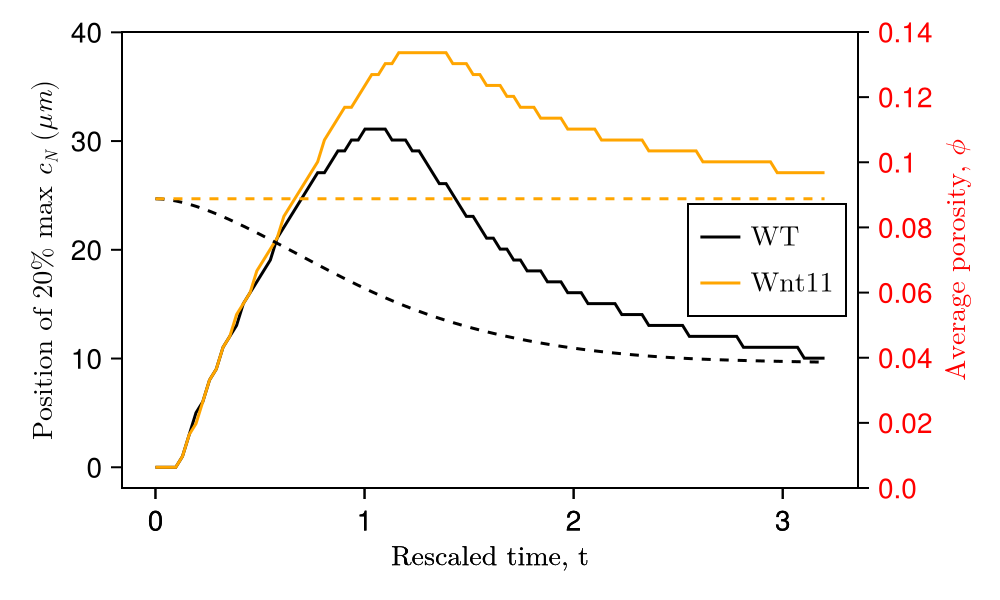

In [24]:
fig = Figure(size = (500,300))

ax = Axis(fig[1,1], xlabel = L"\text{Rescaled time, t}", ylabel= L"\text{Position of 20% max } c_N \text{ } (μm) ",ygridvisible = false,xgridvisible = false)
ax_por = Axis(fig[1,1], xlabel = L"\text{Rescaled time, t}", ylabel= L"\text{Average porosity, } \phi", yaxisposition = :right,ylabelcolor = :red,yticklabelcolor = :red,ygridvisible = false,xgridvisible = false)

lines!(ax,t_plot,level_x_wt_rescaled,color = :black,label = L"\text{WT}")
lines!(ax,t_plot,level_x_cp_rescaled,color = :orange,label = L"\text{Wnt11}")
# lines!(ax,t_plot,level_x_lm,linestyle = :dash,color = :pink,label = L"\text{Lefty mutant}")

lines!(ax_por,t_plot,porosity_dyn ,linestyle = :dash,color = :black,label = L"\text{ϕ}")
lines!(ax_por,t_plot,porosity_dyn_cp ,linestyle = :dash,color = :orange,label = L"\text{ϕ}")

# lines!(ax,exp_times_times_norm ,data[:,"SLB"],color = :blue)
# lines!(ax,exp_times_times_norm ,data[:,"WT"],color = :black)

axislegend(ax,position = :rc)

ylims!(ax_por,0.,0.14)

ax_por.yticks = (0:0.02:0.14,string.(0:0.02:0.14))

save(plotsdir(exp_name * "/OptFits/Fig3E_xmax_over_time_wporosity.pdf"),fig)

fig

In [28]:
to_plot = [:wt_t0,:cp_t0,:xmax_peak_ratio,:wt_xMax,:cp_xMax,:wt_d0,:cp_d0,:lm_d0,:alpha_mse]

fig = Figure(size = (760,760))

grid_ax = Tuple.(findall(x->x>0,ones(3,3)))

for (n,metric) in enumerate(to_plot)
    if metric  == :alpha_mse
        ax = Axis(fig[grid_ax[n]...],xlabel = metric_names_latex[metric],xscale = log10)
        hist!(ax,map(x->transformations[metric](x[metric]),sim_res),normalization = :probability,color = (:grey,0.6),bins = 50)
        vlines!(ax,transformations[metric](orig_metrics[metric]),color = :blue,linestyle = :dash)
        vlines!(ax,transformations[metric](p_opt_metrics[metric]),color = :green,linestyle = :dash)
    else
        ax = Axis(fig[grid_ax[n]...],xlabel = metric_names_latex[metric])
        hist!(ax,map(x->transformations[metric](x[metric]),sim_res),normalization = :probability,color = (:grey,0.6))
        vlines!(ax,transformations[metric](data_metrics[metric]),color = :red,linestyle = :dash, label = L"\text{Experiment}")
        vlines!(ax,transformations[metric](orig_metrics[metric]),color = :blue,linestyle = :dash, label = L"\text{Start param.}")
        vlines!(ax,transformations[metric](p_opt_metrics[metric]),color = :green,linestyle = :dash, label = L"\text{Opt param.}")
    end

    if metric == :xmax_peak_ratio
        axislegend(ax,position = :rt)
    end

end

save(plotsdir(exp_name * "/OptFits/Summary_metrics.pdf"),fig)

fig

LoadError: UndefVarError: sim_res not defined

In [ ]:
p_orig

In [ ]:
p_opt